# Complementi di Probabilità e Statistica
## FRED API

Questo progetto consiste nel creare delle funzioni che permettono di analizzare e costruire grafici dai dati presi da FRED (Federal Reserve Economic Data) (https://fred.stlouisfed.org/).

## **Funzioni** ##
Di seguito verranno analizzati ogni classe contenenti le funzioni che hanno permesso la realizzare di questo progetto e, di conseguenza, lo studio delle osservabili di una serie. 

### **Librerie**
Le librerie utilizzate sono le seguenti (le più importanti):
- sqlite3: per la gestione del database
- matplotlib: per i grafici
- pandas: utilizzata per gestire i dataframe
- seaborn: utilizzato per la creazione della matrice di covarianza
- sklearn: utilizzato per il calcolo della regressione lineare

In [69]:
import os
import sqlite3
import requests
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from matplotlib import pyplot as pyplt

### **constants.py**


In [70]:
url = "https://api.stlouisfed.org/fred/"
name = 'name'
categories_label = 'categories'
parent_id_label = 'parent_id'
children_label = 'children'
series_label = 'series'
seriess_label = 'seriess'
id_label = 'id'
title = 'title'
frequency = 'frequency'
frequency_short = 'frequency_short'
observations_label = 'observations'
date_label = 'date'
value_label = 'value'
type_file = 'json'
dir_graphs = "graph"

# database.py
dir_cat_json = type_file + "/" + categories_label + "-"
dir_series_json = type_file + "/" + series_label + "-"
dir_obs_json = type_file + "/" + observations_label + "-"

# graphs.py
format_date = '%Y-%m-%d'
type_image = "png"
save_type_file = "csv"

# example
database_name = "ProgettoCPS.sqlite"

### **api.py**
In questa classe, le funzioni sono utilizzare per scaricare le categorie, serie e osservazioni a partire da un id:

- categorie, serie: valore numerico;
- osservabili valore: alfanumerico;

Le informazioni vengono scaricati in formato json.

E' stato necessario effettuare un'analisi delle categorie in modo ricorsivo perchè la struttura presentata è ad albero.

Di seguito, funzioni che permettono di scaricare tutte le categorie, serie e osservabili a partire da un id. 

In [71]:
class ApiFred:

    def __init__(self, api_key):
        self.key = api_key
        self.category_URL = "https://api.stlouisfed.org/fred/category?"
        self.children_URL = "https://api.stlouisfed.org/fred/category/children?"
        self.series_URL = "https://api.stlouisfed.org/fred/category/series?"
        self.observations_URL = "https://api.stlouisfed.org/fred/series/observations?"
        self.db = Database(database_name)

    def _get_url(self, tag, value):
        url_link = ""
        if tag == categories_label:
            url_link = self.category_URL + "category_id=" + str(value) + "&api_key=" + self.key + "&file_type=json"
        elif tag == children_label:
            url_link = self.children_URL + "category_id=" + str(value) + "&api_key=" + self.key + "&file_type=json"
        elif tag == series_label:
            url_link = self.series_URL + "category_id=" + str(value) + "&api_key=" + self.key + "&file_type=json"
        elif tag == observations_label:
            url_link = self.observations_URL + "series_id=" + str(value) + "&api_key=" + self.key + "&file_type=json"
        return url_link

    def _get_json(self, tag, value):
        """" get data of single category
                :param value: 
                :param tag: 
                """
        url = self._get_url(tag, value)
        conn = requests.get(url)
        json_data = conn.text
        return json.loads(json_data)

    # Categories
    def get_categories(self, category_key):
        """ Get all category from a category id
        :param category_key: category id
        :return: dictionary category
        """
        category = self._get_json(categories_label, category_key)[categories_label]

        dict_categories = {
            category_key: {name: category[0][name], parent_id_label: category[0][parent_id_label],
                           children_label: {}, series_label: {}}}
        self._recursive_categories(dict_categories)
        write_json(category_key, categories_label, dict_categories)
        self.db.insert_categories(dict_categories, dir_cat_json + str(category_key) + "." + type_file)
        return dict_categories

    def _recursive_categories(self, dict_categories):
        """ Get all category from category id
          """
        for k, v in dict_categories.items():
            if isinstance(v, dict):
                try:
                    for j in self._get_json(children_label, k)[categories_label]:
                        time.sleep(2)
                        list_values = {name: j[name], parent_id_label: j[parent_id_label],
                                       children_label: {}, series_label: {}}
                        v[children_label][j[id_label]] = list_values
                    self._recursive_categories(v[children_label])
                except Exception as e:
                    print(e)

    # Series
    def get_series(self, category_key):
        """ Get all series from category id
        :param category_key: category_id
        :return: dictionary series
        """
        dict_series = self.get_categories(category_key)
        self._recursive_series(dict_series)
        write_json(category_key, series_label, dict_series)
        self.db.insert_series(dict_series, dir_series_json + str(category_key) + "." + type_file)
        return dict_series

    def _recursive_series(self, dict_series):
        """ Get all series from category id
        """
        # for each category it takes id
        for k, v in dict_series.items():
            if isinstance(v, dict):
                if v[series_label].values():
                    self._recursive_series(v[children_label])
                try:
                    for j in self._get_json(series_label, k)[seriess_label]:
                        time.sleep(2)
                        list_values = {title: j[title], frequency: j[frequency_short], parent_id_label: k}
                        v['series'][j['id']] = list_values
                    self._recursive_series(v['children'])
                except Exception as e:
                    print(e)

    # Observations
    def get_observations(self, key):
        """ Get all observation from key
        :param key: key
        :return: dictionary observations
        """
        dict_observations = {}
        if isinstance(key, int):
            dict_series = self.get_series(key)
            self._recursive_observations(dict_series, dict_observations)
        else:
            dict_observations = {key: []}
            for k, v in dict_observations.items():
                dict_observations[k] = self._get_observations_no_recursive(k)
        for k in dict_observations.keys():
            write_json(k, observations_label, dict_observations)
            self.db.insert_observations(dict_observations, dir_obs_json + str(key) + "." + type_file)
        return dict_observations

    def _recursive_observations(self, dict_series, dict_observations):
        """ If key is integer then get all observations recursively
        :param dict_observations: dictionary observations
        :param dict_series: dictionary of series
        """
        # for each category it takes id
        for k, v in dict_series.items():
            if isinstance(v, dict):
                if not v[series_label]:
                    self._recursive_observations(v[children_label], dict_observations)
                for k1 in v[series_label].keys():
                    dict_observations[k1] = self._get_observations_no_recursive(k1)
            self._recursive_observations(v[children_label], dict_observations)

    def _get_observations_no_recursive(self, series_key):
        """ From a series_key get all observations e insert it in a list
            :param series_key: id series
            """
        count = 0
        list_observations = []
        for i in self._get_json("observations", series_key)[observations_label]:
            count += 1
            list_values = {id_label: count, date_label: i[date_label], value_label: i[value_label],
                           "series_key": series_key}
            list_observations.append(list_values)
        return list_observations


### **database.py** ###
All'interno di questo file avviena la connessione con il database SQLite3.
Infatti attraverso create_connection viene creata una connessione con il database specificandone il nome. 
Attraverso le funzioni di questa classe vengono create le tabelle, vengono inserite le informazioni scaricati sul database, metodi che permettono selezionare alcuni record dato un id, di gestire anche la modifica dei dati o la rimozione delle tabelle.
 
I record creati nelle tabelle sono:
- Categorie:
  - id categoria;
  - nome;
  - parent_id

- Serie:
  - id serie;
  - titolo;
  - id categoria

- Osservazioni:
  - id osservabile;
  - data;
  - valore;
  - id serie
  
NB: non sono presenti tutte le funzioni, ma solo quelle necessarie per l'esecuzione del caso di studio.

In [72]:
def _create_table_queries():
    """Metodo contenenti le queries per creare le tabelle categories, series e observations """
    create_table_categories = "CREATE TABLE IF NOT EXISTS categories (" \
                              "category_id int PRIMARY KEY, " \
                              "name varchar(50) not null," \
                              "parent_id int not null);"
    create_table_series = "CREATE TABLE IF NOT EXISTS series (" \
                          "series_id varchar(10) PRIMARY KEY, " \
                          "title varchar(50) not null," \
                          "category_id int not null," \
                          "foreign key(category_id) references categories(category_id));"
    create_table_observation = "CREATE TABLE IF NOT EXISTS observations (" \
                               "observation_id INTEGER PRIMARY KEY autoincrement, " \
                               "date text not null," \
                               "value float," \
                               "series_id varchar(10) not null," \
                               "FOREIGN KEY(series_id) REFERENCES series(series_id));"
    queries = [create_table_categories, create_table_series, create_table_observation]
    return queries


class Database:

    def __init__(self, db_file):
        if db_file.endswith(".sqlite"):
            self.db_file = db_file
        else:
            self.db_file = db_file + ".sqlite"

        self.conn = sqlite3.connect(self.db_file)
        queries = _create_table_queries()
        try:
            cursor = self.conn.cursor()

            for q in queries:
                cursor.execute(q)
                self.conn.commit()
        except Exception as e:
            print(e)

    def insert_categories(self, dict_categories, file_path):
        """ Metodo che permette di inserire record all'interno della tabella categories
            :param dict_categories: dictionary della categoria
            :param file_path: json path
            :exception Exception: """
        insert_sql = "replace into categories (category_id, name, parent_id) values (?, ?, ?);"

        try:
            # if there is a json file with the values then it gets the records from here,
            # otherwise
            if not os.path.exists(file_path) & (os.stat(file_path).st_size == 0):
                self.insert_value_categories(dict_categories, insert_sql)
            else:
                list_categories_json = open_json(file_path)
                self.insert_value_categories(list_categories_json, insert_sql)
        except Exception as e:
            print("Error for insert categories", e)
        self.conn.commit()

    def insert_value_categories(self, dict_category, sql):
        """ Metodo che in modo ricorsivo esegue la query per inserire i record all'interno della tabella
            :param dict_category: dictionary della categoria
            :param sql: sql script """
        for k, v in dict_category.items():
            data = (k, v[name], v[parent_id_label])
            self.conn.cursor().execute(sql, data)
            if isinstance(v, dict):
                self.insert_value_categories(v[children_label], sql)

    def insert_series(self, dict_series, file_path):
        """ Metodo che permette di inserire record all'interno della tabella series
            :param dict_series: dictionary della serie
            :param file_path: json path
            :exception Exception: """
        insert_sql = "replace into series (series_id, title, category_id) values (?, ?, ?);"

        try:
            # if there is a json file with the values then it gets the records from here,
            # otherwise
            if not os.path.exists(file_path) & (os.stat(file_path).st_size == 0):
                self.insert_value_series(dict_series, insert_sql)
            else:
                dict_series = open_json(file_path)
                self.insert_value_series(dict_series, insert_sql)
        except Exception as e:
            print("Error for insert series", e)
        self.conn.commit()

    def insert_value_series(self, dict_series, sql):
        """ Metodo che in modo ricorsivo esegue la query per inserire i record all'interno della tabella
        :param dict_series: dictionary della serie
        :param sql: sql script """
        for k, v in dict_series.items():
            if isinstance(v, dict):
                if not v[series_label]:
                    self.insert_value_series(v[children_label], sql)

                for k1, v1 in v[series_label].items():
                    data = (k1, v1[title], v1[parent_id_label])
                    self.conn.cursor().execute(sql, data)
                self.insert_value_series(v[children_label], sql)

    def insert_observations(self, dict_observations, file_path):
        """ Metodo che permette di inserire record all'interno della tabella observations
            :param dict_observations: dictionary delle osservabili
            :param file_path: json path
            :exception Exception: """
        insert_sql = "replace into observations (observation_id, date, value, series_id) " \
                     "values (?, ?, ?, ?);"
        try:
            # if there is a json file with the values then it gets the records from here,
            # otherwise
            if not os.path.exists(file_path) & (os.stat(file_path).st_size == 0):
                self.insert_value_observations(dict_observations, insert_sql)
            else:
                dict_observations = open_json(file_path)
                self.insert_value_observations(dict_observations, insert_sql)
        except Exception as e:
            print("Error for insert observations", e)
        self.conn.commit()

    def insert_value_observations(self, dict_observations, sql):
        """ Metodo che in modo ricorsivo esegue la query per inserire i record all'interno della tabella
        :param dict_observations: dictionary delle osservabili
        :param sql: sql script """
        for k, v in dict_observations.items():
            for v1 in v:
                data = (v1["id"], v1[date_label], v1[value_label], v1["series_key"])
                self.conn.cursor().execute(sql, data)

    def close_db(self):
        """Metodo che chiude la connessione con il database """
        self.conn.close()


### **graphs.py**
Le funzioni all'interno di questo modulo permettono di costruire dei grafici, riguardanti:

media mobile
differenza prima
differenza percentuale
covarianza
regressione lineare
Di seguito, funzioni che permettono di rappresentare graficamente le funzioni sopra elencate:

In [73]:
def _define_date_axis():
    """Metodo che calcola la distanza tra una data e un'altra """
    # frequency date in x-axis
    fig = plt.figure()
    ax = fig.add_subplot()
    year = mdates.YearLocator(10)
    ax.xaxis.set_major_locator(year)
    fig.autofmt_xdate(rotation=45)


def _formatter_date_in_axis(dataframe):
    """ Metodo che trasforma una formato stringa in data
    :param dataframe: key-value: date-value
    :return: valore in formato date """
    # formatter dates
    date_formatter = [dt.datetime.strptime(d, format_date).date() for d in dataframe[date_label]]
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    return date_formatter


class Graph:

    def __init__(self, series_key, data_dict):
        self.series_key = series_key
        self.data_dict = data_dict
        self.model = Model(data_dict)

    def media_mobile(self, parameter_days, interpolation_bool):
        """Metodo che permette di creare un grafico sulla media mobile.
        Media mobile: linear, weighted and exponential
        :param interpolation_bool: vero se si vuole effettuare un'interpolazione; altrimenti
        :param parameter_days: parametro n giorni """
        df_observations = self._if_interpolation(interpolation_bool)

        if not isinstance(self.data_dict, pd.DataFrame):
            df_observations = self.model.get_observations()

        list_date = _formatter_date_in_axis(df_observations)
        _define_date_axis()
        self._pplot(df_observations, list_date)

        weights = np.arange(1, parameter_days + 1)
        df_observations['SMA'] = df_observations[value_label].rolling(window=parameter_days).mean()
        df_observations['WMA'] = df_observations[value_label].rolling(parameter_days) \
            .apply(lambda value: np.dot(value, weights) / weights.sum(), raw=True)
        df_observations['EMA'] = df_observations[value_label].ewm(span=parameter_days).mean()
        df_observations.to_csv("csv/media-mobile-" + self.series_key + "." + save_type_file)

        plt.plot(list_date, df_observations['SMA'], linewidth=1, color="green", label='SMA - ' + str(parameter_days))
        plt.plot(list_date, df_observations['WMA'], linewidth=1, color="red", label='WMA - ' + str(parameter_days))
        plt.plot(list_date, df_observations['EMA'], linewidth=1, color="orange", label='EMA - ' + str(parameter_days))
        self.set_plot("Media mobile", "media-mobile-" + str(parameter_days) + "days")
        plt.show()

    def covariance(self, series_id, dataframe):
        """ Metodo che permette di creare un grafico sulla covarianza
        :param dataframe: records delle osservabili
        :param series_id: lista id della serie
        """
        if not isinstance(dataframe, pd.DataFrame):
            dataframe = self.model.get_observations()
            dataframe['value'] = dataframe['value'].astype('float')
        else:
            dataframe[series_id] = dataframe[series_id].astype('float')

        if len(series_id) > 1:
            covariance_matrix = pd.DataFrame.cov(dataframe)
            plt.figure(figsize=(20, 5))
            sns.heatmap(covariance_matrix, annot=True, fmt='g', xticklabels=series_id, yticklabels=series_id)
            plt.title("Covariance")
            plt.savefig("graph/" + "covariance" + "-" + str(series_id) + ".png")
            plt.show()

    def difference_plot(self, interpolation_bool):
        """Metodo che permette di creare un grafico sulle differenze prime
        :param interpolation_bool: vero se si vuole effettuare un'interpolazione; altrimenti """
        dataframe = self._if_interpolation(interpolation_bool)

        if not isinstance(dataframe, pd.DataFrame):
            dataframe = self.model.get_observations()
        list_date = _formatter_date_in_axis(dataframe)
        dataframe['value'] = dataframe['value'].astype('float')
        dataframe['difference'] = dataframe['value'].diff()
        plt.plot(list_date, dataframe['difference'], "-", linewidth=1, label='Observations - ' + self.series_key)

    def percentage_plot(self, interpolation_bool):
        """Metodo che permette di creare un grafico sulla differenza percentuale
        :param interpolation_bool: vero se si vuole effettuare un'interpolazione; altrimenti """
        dataframe = self._if_interpolation(interpolation_bool)

        if not isinstance(dataframe, pd.DataFrame):
            dataframe = self.model.get_observations()
        list_date = _formatter_date_in_axis(dataframe)
        dataframe['value'] = dataframe['value'].astype('float')
        dataframe['percentage'] = dataframe['value'].pct_change()
        plt.plot(list_date, dataframe['percentage'], "-", linewidth=1, label='Observations - ' + self.series_key)

    def linear_regression(self, dataframe):
        """Metodo che permette di creare un grafico sulla regressione lineare
        :param dataframe: key-value: date-value """
        list_date = _formatter_date_in_axis(dataframe)
        dataframe['days_from_start'] = (dataframe.index - dataframe.index[0])

        x = dataframe['days_from_start'].values.reshape(-1, 1)
        y = dataframe['value'].values

        regression = linear_model.LinearRegression()
        regression.fit(x, y)
        date_start = list_date[0]
        date_end = list_date[len(list_date) - 1]

        plt.figure(figsize=(10, 5))
        plt.scatter(list_date, y, color='green', marker='x', linewidth=1,
                    label='Observations - ' + str(self.series_key))
        plt.xlim([date_start, date_end])
        plt.plot(list_date, regression.predict(x), "-", color='red', linewidth=1, label='Regression')

        self.set_plot("Linear Regression", "linear_regression")
        plt.show()

    def plot_observations(self, interpolation_bool):
        """Metodo che permette di creare un grafico sulle osservabili di una serie
        :param interpolation_bool: vero se si vuole effettuare un'interpolazione; altrimenti """
        df_observations = self._if_interpolation(interpolation_bool)

        if not isinstance(self.data_dict, pd.DataFrame):
            df_observations = self.model.get_observations()
        # takes the formatted dates
        list_date = _formatter_date_in_axis(df_observations)
        _define_date_axis()
        self._pplot(df_observations, list_date)
        self.set_plot("Observations", observations_label)
        plt.show()

    def set_plot(self, name_graph, name_png):
        """Metodo che imposta il layout di un plot
        :param name_graph: nome da assegnare al grafico
        :param name_png: nome da assegnare al file png """
        # layout plot
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(format_date))
        plt.title(name_graph)
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.grid(which='both', color='#CCCCCC', linestyle='--')
        plt.legend()
        plt.savefig("graph/" + name_png + "-" + self.series_key + "." + type_image)

    def _pplot(self, dataframe, list_date):
        """ Plots
        :param dataframe:  key-value: date-value
        :param list_date: list date formatted """
        dataframe[value_label] = dataframe[value_label].astype('float')
        plt.plot(list_date, dataframe[value_label], "-", linewidth=1,
                 label=observations_label + ' - ' + self.series_key)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(format_date))

    def _if_interpolation(self, interpolation_bool):
        """Metodo che ritorna una lista di osservabili in base se è stata effetuata un'interpolazione o meno
        :param interpolation_bool: vero se si vuole effettuare un'interpolazione; altrimenti
        :return: dataframe delle osservabili """
        if interpolation_bool:
            df_observations = self.model.linear_interpolation()
        else:
            df_observations = self.model.get_observations()
        return df_observations


### **model.py**
In questo file esistono due funzioni diverse per poter calcolare l'interpolazione. Una funzione che attraverso una formula determina il valore dei Nan e un'altra funzione che attraverso il dataframe calcola automaticamanete l'interpolazione dei valori.

Di seguito, le funzioni che permettono di calcolare l'interpolazione dei dati in entrambi i modi:

La prima funzione calcola l'interpolazione con la funzione del dataframe;
la seconda e terza funzione calcola l'interpolazione attraverso la formula:
(s(k) - s(j) - (i - j) / (k - j) + s(j) con k>i e j<i.

In [74]:
def _formula_interpolation(index, values):
    """Metodo contenente la formula per il calcolo dell'interpolazione
    :param index: indice che specifica dove si trova il valore mancante
    :param values: lista dei valori
    :return: formula """
    # it takes the preceding index and the successor of the i-th and
    # returns the formula of the linear interpolation
    index_pre = index - 1
    index_succ = index + 1
    return (values[index_succ] - values[index_pre]) * (index - index_pre) / \
        (index_succ - index_pre) + values[index_pre]


class Model:

    def __init__(self, data_dict):
        self.data_dict = data_dict

    def get_observations(self):
        """Metodo che trasforma una dictionary in un dataframe
        :return: dataframe
        """
        list_id = []
        list_date = []
        list_value = []
        for row in self.data_dict:
            for i in self.data_dict[row]:
                list_id.append(i['id'])
                list_date.append(i['date'])
                list_value.append(i['value'])

        df = pd.DataFrame(list(zip(list_id, list_date, list_value)), columns=["id", date_label, value_label])
        return df

    def interpolate_dataframe(self):
        """Metodo che calcola l'interpolazione di un dataframe se esistono valori NaN
            :return: dataframe """
        dataframe = self.get_observations()
        dataframe[value_label] = pd.to_numeric(dataframe[value_label], errors='coerce')
        dataframe[value_label] = dataframe[value_label].interpolate()

        return dataframe

    def linear_interpolation(self):
        """Metodo che calcola l'interpolazione dei dati dato una dictionary
        :return: dictionary delle osservabili """
        list_observations = {}

        for i in self.data_dict.items():
            count = 0
            for j in i[1]:
                count += 1
                list_observations[count] = j

        for index, value in enumerate(list_observations.values()):
            values = list(list_observations.values())

            if value['value'] == 0.0:
                value['value'] = _formula_interpolation(index, values)
                list_observations[index] = value['value']
        return list_observations


### **json_file.py**
Le funzioni di questo modulo permettono di scrivere le informazioni e l'apertura/lettura di un file.

In [75]:
def open_json(file_path):
    """Metodo che permette la lettura di un file json
    :param file_path: path json
    :return: json data """
    with open(file_path) as data_file:
        return json.load(data_file)


def create_directory():
    """Metodo che permette la creazione di cartelle se non esistono """
    if not os.path.exists(type_file):
        os.makedirs(type_file)
    if not os.path.exists(save_type_file):
        os.makedirs(save_type_file)
    if not os.path.exists(dir_graphs):
        os.makedirs(dir_graphs)


def write_json(key, name_file, list_records):
    """Metodo che scrive tutti i record in un file
    :param name_file: nome del file
    :param list_records: lista dei record: categories, series or observations
    :param key: id category, series or observation """
    create_directory()
    with open(type_file + '/' + name_file + '-' + str(key) + '.' + type_file, 'w') as fp:
        json.dump(list_records, fp)


## **Case Study** 📓
Consideriamo tre serie di una stessa categoria per determinare la media mobile, covarianza, differenza prima, differenza percentuale, regressione lineare.

In [76]:
series_id = ["PHMEPRPIHCSA", "MNINEIPIMEPS", "DIMSCTPIMEPS"]
apiKey = "b933025b5b47791c3552c8ce24305e99"

### **Grafico con tre serie di osservabili**
Il metodo plot_observations() permette di graficare l'andamento delle tre serie
prendendo come input la data e il valore (espresso in float) di ogni osservabile. 

<Figure size 720x360 with 0 Axes>

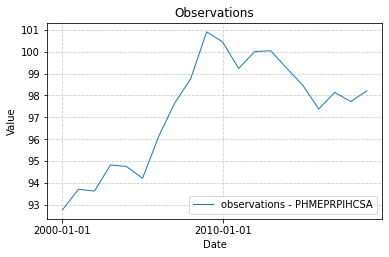

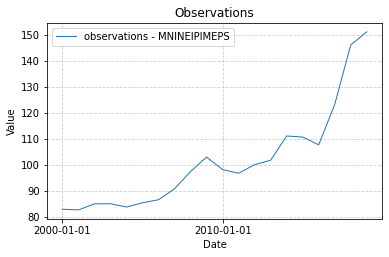

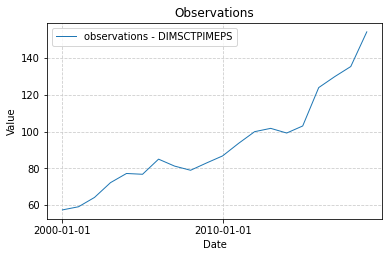

In [77]:
def plot_observation():
        """ From a list of keys series determine the plot, difference,
        percentage difference, covariance and linear regression of the observations
        """
        api = ApiFred(apiKey)
        # for each series retrieve the values of the observations and write them on json.
        # Create databases and recover data.
        # Plot the observations together
        # Plot observations
        pyplt.figure(figsize=(10, 5))
        for j in series_id:
            list_observations = api.get_observations(j)

            graph = Graph(j, list_observations)
            graph.plot_observations(True)

        pyplt.show()

plot_observation()

### **Grafico media mobile**
La media mobile permette di graficare l'andamento di una osservaile specificando il valore della finestra. 

Per ogni osservabile, determina la media mobile lineare, pesata ed esponenziale.

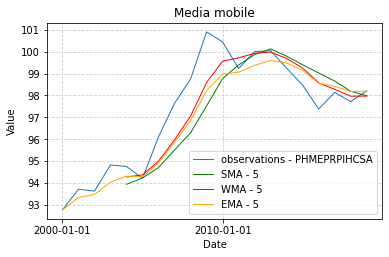

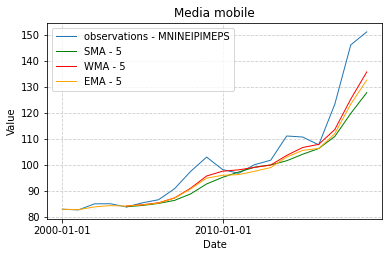

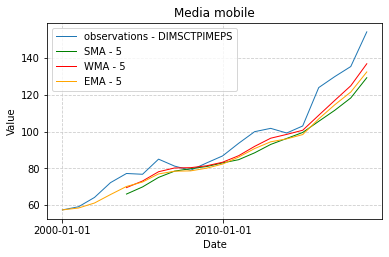

In [78]:
def media_mobile():
  global graphs
  api = ApiFred(apiKey)
  for j in series_id:
     list_observations = api.get_observations(j)

     graphs = Graph(j, list_observations)
     graphs.media_mobile(5, True)
  pyplt.show()

media_mobile()

### **Differenze prime**
Questa funzione permette di graficare le differenze prime utilizzando il metodo diff del package pandas e di calcolare, quindi, i valori finali.
La formula per calcolare le differenze prime, utilizzata nel metodo diff() è:
$$ y_i = x_i - x_{i-1}, \forall i = 2,...,n $$



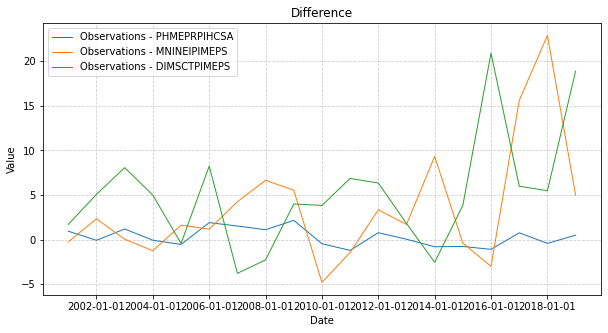

In [79]:
def diff_prime():
        global graphs
        api = ApiFred(apiKey)
        # for each series create difference plots
        # Plot difference s(i-1) -s(i)
        pyplt.figure(figsize=(10, 5))
        for j in series_id:
            list_observations = api.get_observations(j)

            graphs = Graph(j, list_observations)
            graphs.difference_plot(True)

        graphs.set_plot("Difference", "difference")
        pyplt.show()
  
diff_prime()

### **Differenze percentuali**
Questa funzione permette di graficare le differenze percentuali utilizzando il metodo pct_change del package pandas e di calcolare, quindi, i valori finali.
La formula per calcolare le differenze percentuali, utilizzata nel metodo pct_change() è: 
$$ y_i = \frac{x_i - x_{i-1}}{x_{i-1}}, \forall i = 2,...,n $$

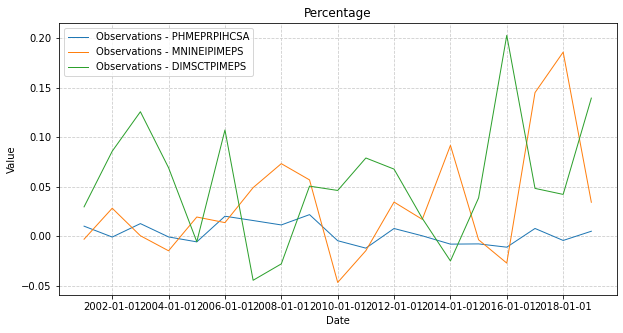

In [80]:
def diff_percentage():
        global graphs
        api = ApiFred(apiKey)
        # for each series, create plot of the percentage differences
        # Plot difference percentage (s(i-1)-s(i))/s(i)
        pyplt.figure(figsize=(10, 5))
        for j in series_id:
            list_observations = api.get_observations(j)

            graphs = Graph(j, list_observations)
            graphs.percentage_plot(True)

        graphs.set_plot("Percentage", "percentage")
        pyplt.show()

diff_percentage()

### **Covarianza**
La funzione covariance() permette di graficare le osservabile di queste tre serie creando una matrice. La covarianza utilizza il metodo cov() del package pandas. 

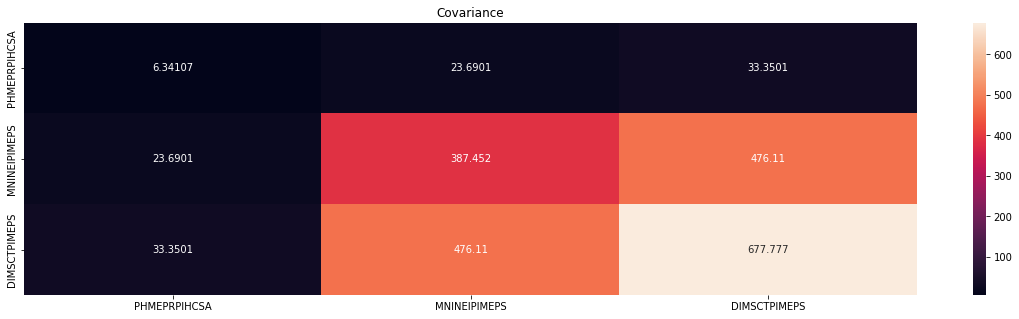

In [81]:
def covariance():
        # Covariance
        global graphs
        api = ApiFred(apiKey)

        dataframe = pd.DataFrame()
        count = 0
        for j in series_id:
            list_observations = api.get_observations(j)

            graphs = Graph(j, list_observations)
            model = Model(list_observations)

            ob_df = model.get_observations()
            dataframe.insert(count, j, ob_df['value'], True)
            count += 1

        graphs.covariance(series_id, dataframe)

covariance()

### **Regressione lineare**
La funzione lineare_regression() permette di calcolare e graficare la retta di regressione delle osservabili di una serie. Si utilizza il package sklearn che contiene la funzione '.LinearRegression()'. 
La formula usata per calcolare i punti della retta di regressione è:
$$ b_0 = \bar{y}_n - \frac{\sum_{k=1}^n (x_k -\bar{x}_n)(y_k-\bar{y}_n)}{\sum_{k=1}^n (x_k -\bar{x}_n)^2}\cdot \bar{x}_n $$
$$
    b_1 = \frac{\sum_{k=1}^n (x_k -\bar{x}_n)(y_k-\bar{y}_n)}{\sum_{k=1}^n (x_k -\bar{x}_n)^2}
$$

$$ y_k = b_0 +b_1\cdot x_k, \forall k = 1,...,n $$

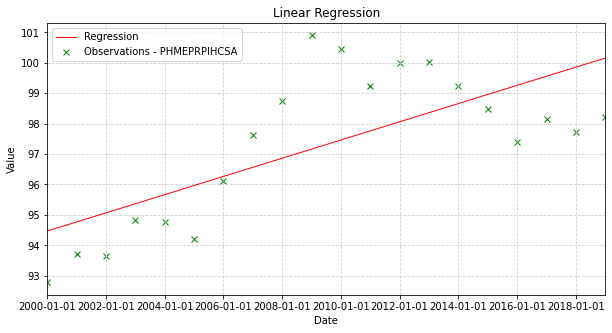

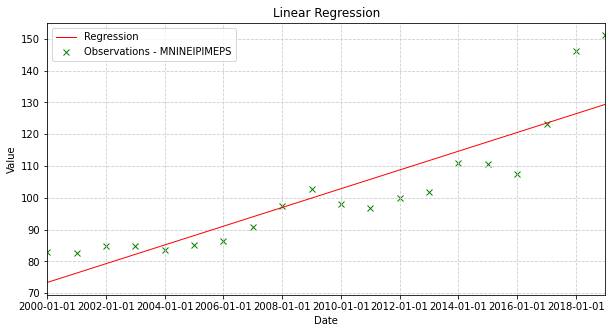

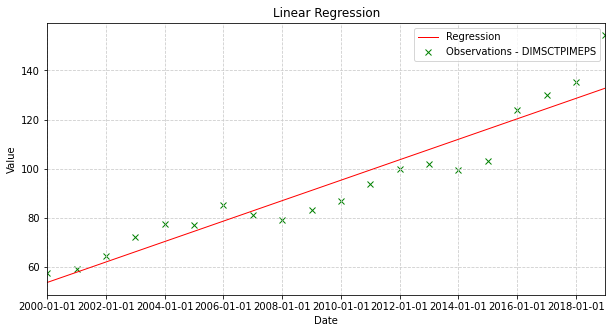

In [82]:
def linear_regression():
        # Linear regression
        global graphs
        api = ApiFred(apiKey)

        for j in series_id:
            list_observations = api.get_observations(j)

            graphs = Graph(j, list_observations)
            model = Model(list_observations)

            df = model.interpolate_dataframe()
            graphs.linear_regression(df)

linear_regression()